In [3]:
import os
import sys
import json
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import datetime
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath("./maskrcnn")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library


from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap
from numpy import expand_dims
from numpy import mean
from matplotlib.patches import Rectangle
from mrcnn.model import MaskRCNN
import skimage

from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from mrcnn.visualize import display_instances, display_top_masks
from mrcnn.utils import extract_bboxes


from mrcnn.utils import Dataset

#from mrcnn import model as modellib, utils
from PIL import Image, ImageDraw

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

2024-07-16 22:55:22.696913: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 22:55:22.744471: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 22:55:22.744521: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 22:55:22.744569: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-16 22:55:22.755353: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-16 22:55:22.756064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [4]:
#CONSTANTS

PATCH = './'
PATCH_IMGAGE = './train'

In [5]:
ROOT_DIR

'/home/dron/Peton/hakaton_ekf/AUT_ekf_dataset/maskrcnn'

In [7]:
###################################################


In [8]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "marble_cfg_coco"
	# number of classes (background + Blue Marbles + Non Blue marbles)
	NUM_CLASSES = 1 + 4
	# Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1


In [9]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, 
                                                                        # use_mini_mask=False
                                                                        )
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP


In [10]:
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='logs', config=cfg)
# load model weights
model_path = os.path.join(ROOT_DIR, "mask_rcnn_shapes_fine_tune.h5")
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use fn_output_signature instead


2024-07-16 22:55:54.750697: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled


## Проверка на одном изображении

Processing 1 images
image                    shape: (1241, 1755, 3)       min:   17.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max: 1755.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


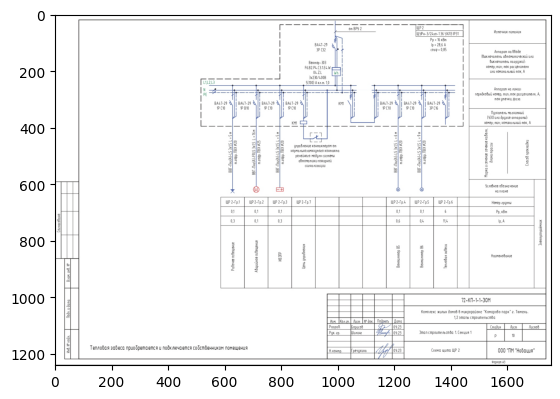

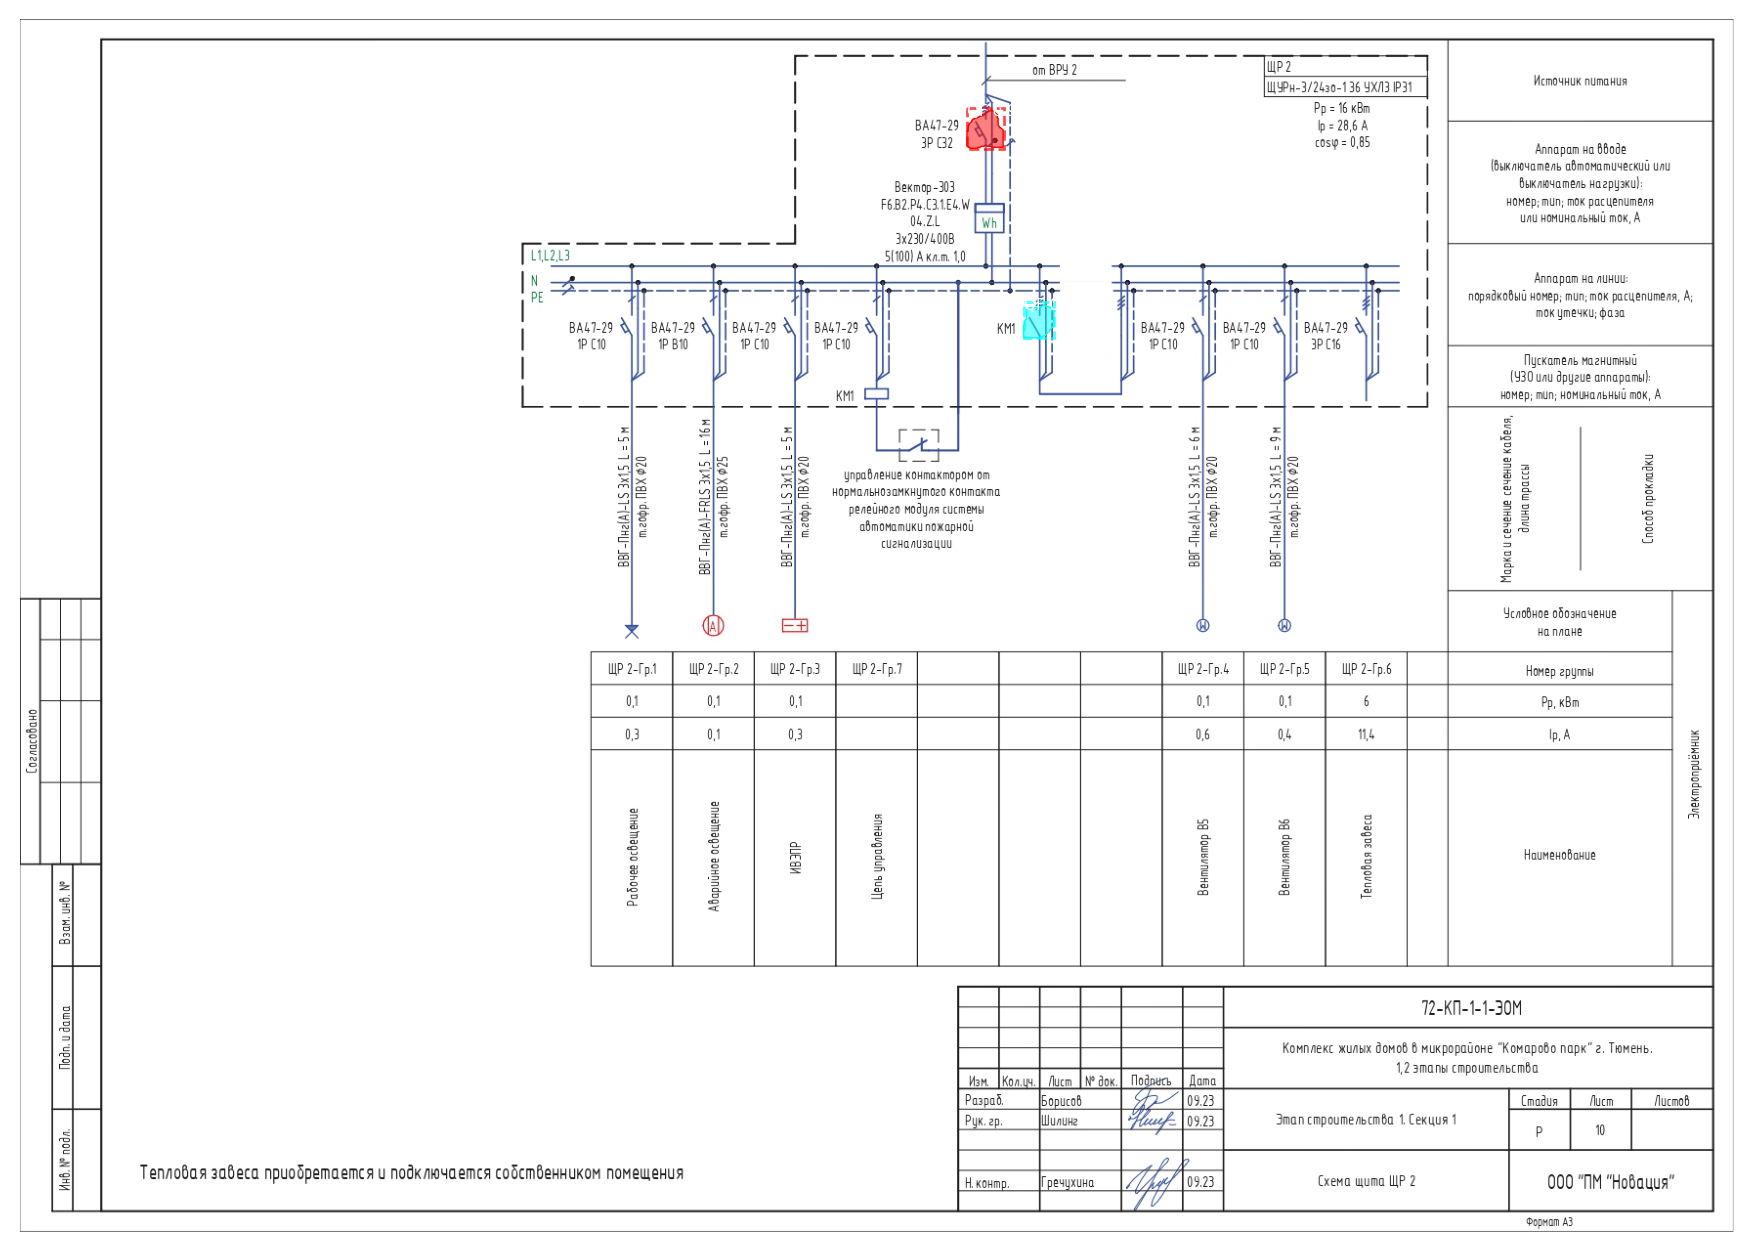

In [15]:
#Проверка на одном изображении

#путь к фото
path = "./train/999.jpg"
marbles_img = skimage.io.imread(path)
plt.imshow(marbles_img)

detected = model.detect([marbles_img], verbose=1)
results = detected[0]
class_names = ['NONE', 'QF', 'TT', 'HL', 'PI']
display_instances(marbles_img, results['rois'], results['masks'], 
                  results['class_ids'], class_names, results['scores'], 
                  figsize=(26, 16)
                 )


In [16]:
#классы изображений
# 1 - QF
# 2 - TT
# 3 - HL
# 4 - PI

results['class_ids']

array([1, 1], dtype=int32)

In [17]:
# вероятности опредения этих классов
results['scores']

array([0.9354623 , 0.76696783], dtype=float32)

In [18]:
# коородинаты изображений
results['rois']

array([[  90,  970,  132, 1007],
       [ 289, 1028,  326, 1059]], dtype=int32)